# Pharyngeal endoderm development analysis with WOT

## Import packages

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scanpy as sc
import scvelo as scv
import wot

from cr2 import running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 2
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm", exist_ok=True)

SHOW_COLORBAR = not SAVE_FIGURES

In [5]:
(DATA_DIR / "pharyngeal_endoderm" / "results").mkdir(parents=True, exist_ok=True)

## Constants

In [6]:
# fmt: off
S_GENES = [
    "Mcm5", "Pcna", "Tyms", "Fen1", "Mcm2", "Mcm4", "Rrm1", "Ung", "Gins2",
    "Mcm6", "Cdca7", "Dtl", "Prim1", "Uhrf1", "Mlf1ip", "Hells", "Rfc2",
    "Rpa2", "Nasp", "Rad51ap1", "Gmnn", "Wdr76", "Slbp", "Ccne2", "Ubr7",
    "Pold3", "Msh2", "Atad2", "Rad51", "Rrm2", "Cdc45", "Cdc6", "Exo1",
    "Tipin", "Dscc1", "Blm", "Casp8ap2", "Usp1", "Clspn", "Pola1", "Chaf1b",
    "Brip1", "E2f8",
]

G2M_GENES = [
    "Hmgb2", "Cdk1", "Nusap1", "Ube2c", "Birc5", "Tpx2", "Top2a", "Ndc80",
    "Cks2", "Nuf2", "Cks1b", "Mki67", "Tmpo", "Cenpf", "Tacc3", "Fam64a",
    "Smc4", "Ccnb2", "Ckap2l", "Ckap2", "Aurkb", "Bub1", "Kif11", "Anp32e",
    "Tubb4b", "Gtse1", "Kif20b", "Hjurp", "Cdca3", "Hn1", "Cdc20", "Ttk",
    "Cdc25c", "Kif2c", "Rangap1", "Ncapd2", "Dlgap5", "Cdca2", "Cdca8",
    "Ect2", "Kif23", "Hmmr", "Aurka", "Psrc1", "Anln", "Lbr", "Ckap5",
    "Cenpe", "Ctcf", "Nek2", "G2e3", "Gas2l3", "Cbx5", "Cenpa",
]
# fmt: on

In [7]:
TERMINAL_STATES = ["mTEC", "cTEC", "parathyroid", "ubb"]

## Data loading

In [8]:
adata = sc.read(DATA_DIR / "pharyngeal_endoderm" / "raw" / "adata_pharynx.h5ad")
adata.obsm["X_umap"] = adata.obs[["UMAP1", "UMAP2"]].values
adata.obs["day"] = adata.obs["day_str"].astype(float)
adata.obs = adata.obs[["cluster_name", "day", "is_doublet"]]

adata.obs["cluster_fine"] = (
    pd.read_csv(DATA_DIR / "pharyngeal_endoderm" / "raw" / "cluster_data.csv", index_col=0)
    .loc[adata.obs_names, "res.1"]
    .values
)
adata.obs["cluster_fine"] = adata.obs["cluster_fine"].astype(str).astype("category")

adata = adata[adata.obs["cluster_fine"].isin(["2", "4", "9", "12", "25", "26"]), :].copy()
adata.uns["cluster_name_colors"] = ["#023fa5", "#bec1d4", "#b5bbe3", "#e07b91", "#11c638"]

adata

AnnData object with n_obs × n_vars = 11073 × 27998
    obs: 'cluster_name', 'day', 'is_doublet', 'cluster_fine'
    uns: 'cluster_name_colors'
    obsm: 'X_umap'

In [9]:
mouse_tfs = (
    pd.read_csv(DATA_DIR / "generic" / "mouse_tfs.tsv", sep="\t", header=None)
    .rename(columns={0: "Ensemble ID", 1: "Gene ID"})["Gene ID"]
    .tolist()
)

## Data preprocessing

In [10]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:03)


In [11]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:02:28)


In [12]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:06)


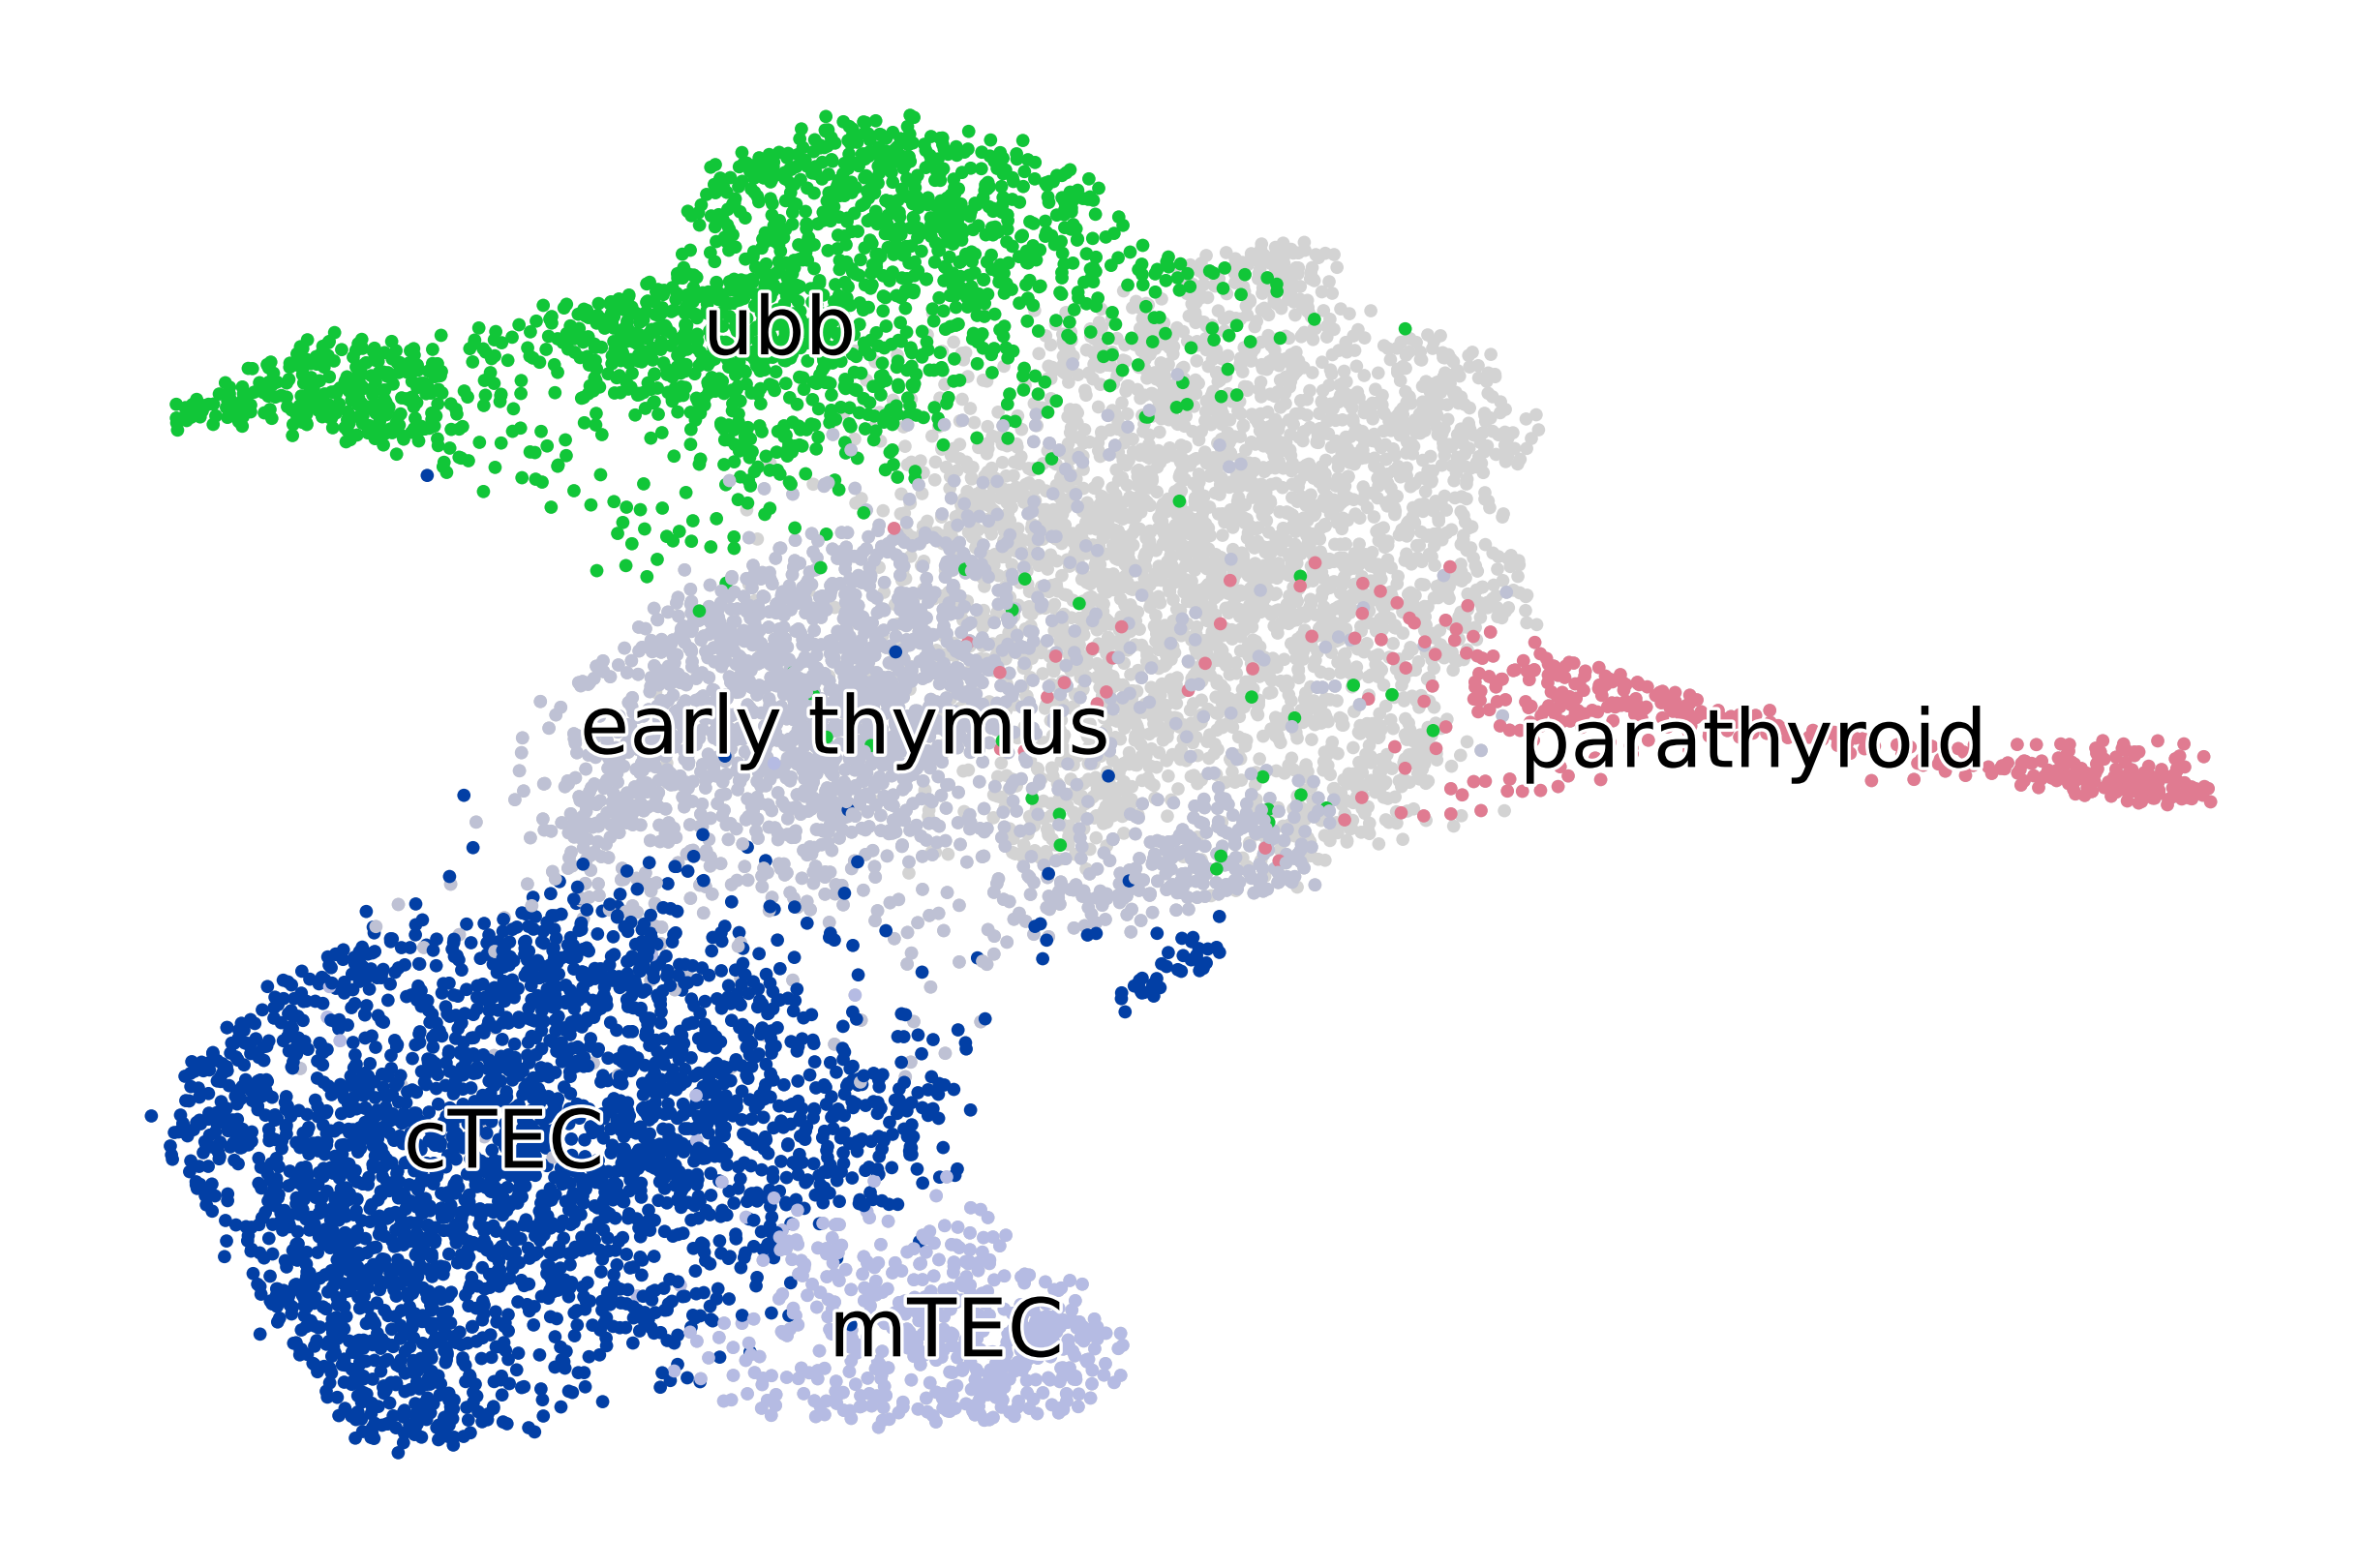

In [13]:
if running_in_notebook():
    scv.pl.scatter(
        adata, basis="umap", c="cluster_name", title="", dpi=250, legend_fontsize=12, legend_fontweight="normal"
    )

## WOT

In [14]:
if not (DATA_DIR / "pharyngeal_endoderm" / "tmaps_subsetted_data").exists():
    ot_model = wot.ot.OTModel(adata)
    ot_model.compute_all_transport_maps(tmap_out=DATA_DIR / "pharyngeal_endoderm" / "tmaps_subsetted_data" / "tmaps")

In [15]:
cell_sets = {
    terminal_state: adata.obs_names[
        adata.obs["cluster_name"].isin([terminal_state]) & adata.obs["day"].isin([12.5])
    ].tolist()
    for terminal_state in TERMINAL_STATES
}

In [16]:
tmap_model = wot.tmap.TransportMapModel.from_directory(
    DATA_DIR / "pharyngeal_endoderm" / "tmaps_subsetted_data" / "tmaps"
)
populations = tmap_model.population_from_cell_sets(cell_sets, at_time=12.5)

In [17]:
res = tmap_model.pull_back(populations[0], to_time=10.5)

In [18]:
trajectory_ds = tmap_model.trajectories(populations)

In [19]:
for cell_type in TERMINAL_STATES:
    adata.obs[f"traj_{cell_type}"] = trajectory_ds[:, cell_type].X.squeeze().copy()

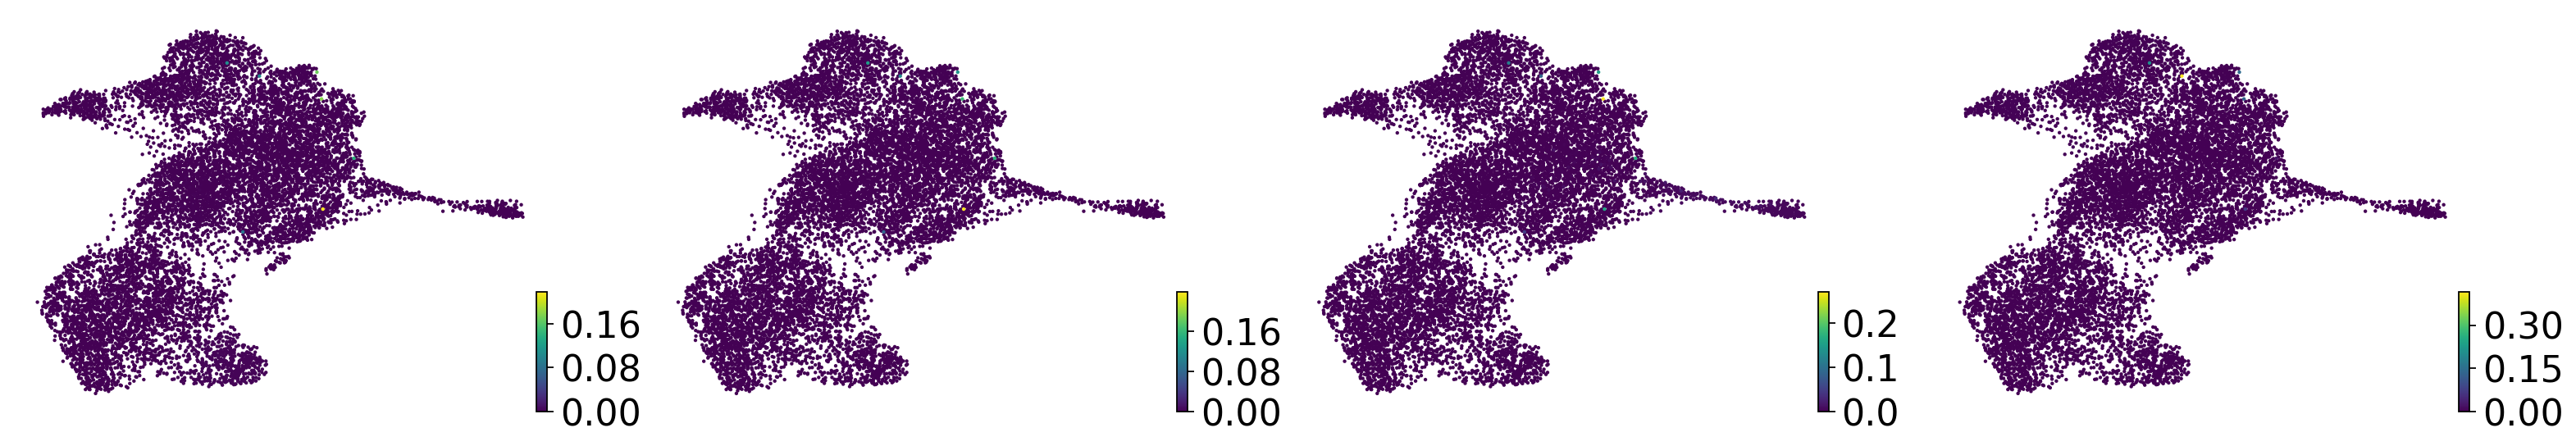

In [20]:
if running_in_notebook():
    scv.pl.scatter(
        adata,
        basis="umap",
        c=[f"traj_{terminal_state}" for terminal_state in TERMINAL_STATES],
        cmap="viridis",
        title="",
        legend_loc=None,
    )

if SAVE_FIGURES:
    for terminal_state in TERMINAL_STATES:
        fig, ax = plt.subplots(figsize=(6, 4))

        if running_in_notebook():
            scv.pl.scatter(
                adata,
                basis="umap",
                color=f"traj_{terminal_state}",
                s=50,
                cmap="viridis",
                title="",
                colorbar=SHOW_COLORBAR,
                ax=ax,
            )

            fig.savefig(
                FIG_DIR
                / "realtime_kernel"
                / "pharyngeal_endoderm"
                / f"wot_pullback_{terminal_state}_subsetted_data.eps",
                format="eps",
                transparent=True,
                bbox_inches="tight",
            )

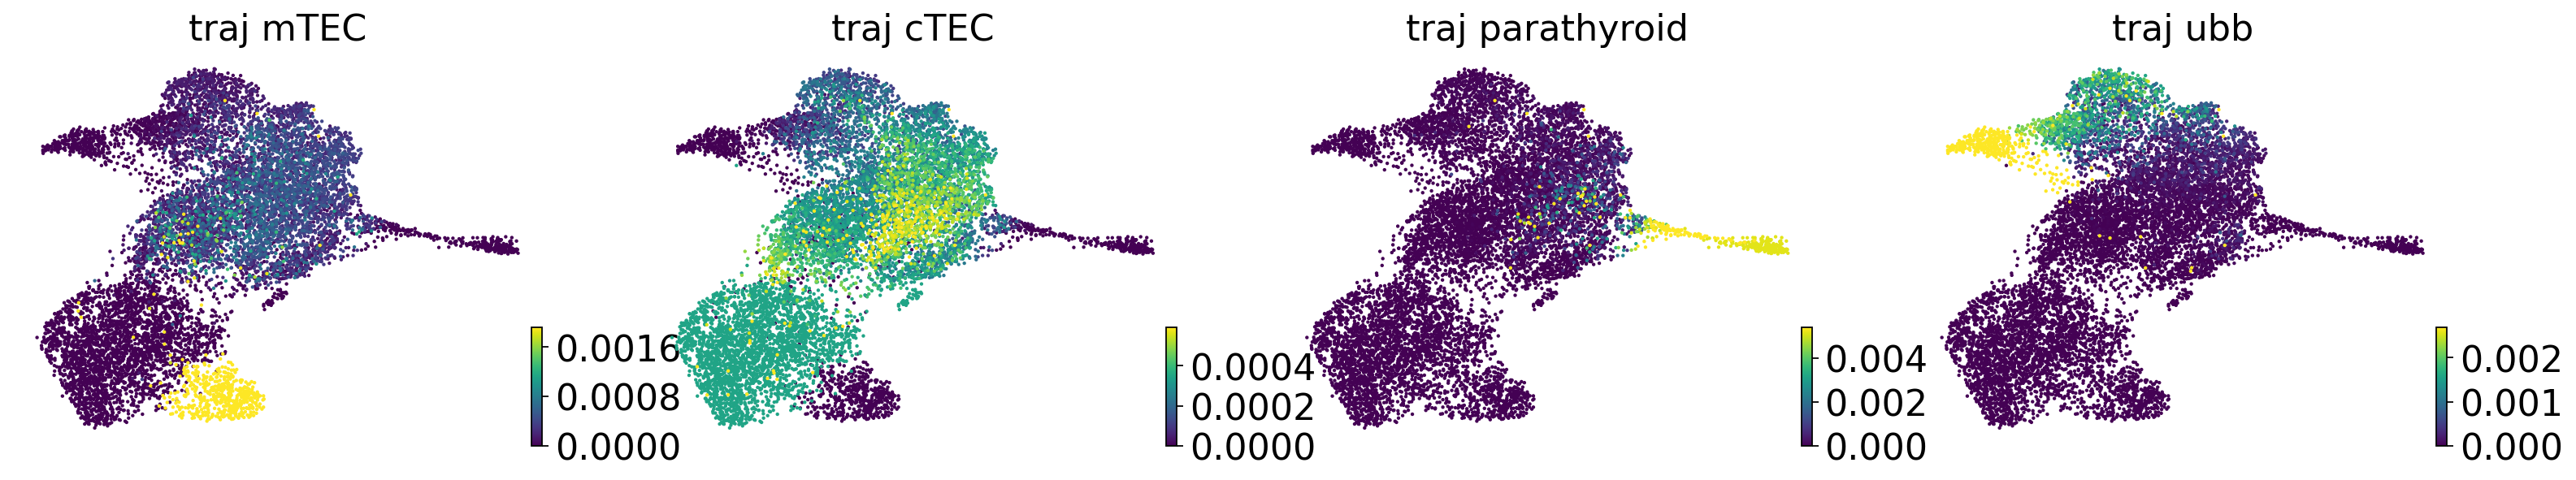

In [21]:
if running_in_notebook():
    scv.pl.scatter(
        adata,
        basis="umap",
        c=[f"traj_{terminal_state}" for terminal_state in TERMINAL_STATES],
        cmap="viridis",
        # title="",
        legend_loc=None,
        perc=[0, 99],
    )

if SAVE_FIGURES:
    for terminal_state in TERMINAL_STATES:
        fig, ax = plt.subplots(figsize=(6, 4))

        if running_in_notebook():
            scv.pl.scatter(
                adata,
                basis="umap",
                color=f"traj_{terminal_state}",
                s=50,
                cmap="viridis",
                title="",
                colorbar=SHOW_COLORBAR,
                perc=[0, 99],
                ax=ax,
            )

            fig.savefig(
                FIG_DIR
                / "realtime_kernel"
                / "pharyngeal_endoderm"
                / f"wot_pullback_{terminal_state}_clipped_subsetted_data.eps",
                format="eps",
                transparent=True,
                bbox_inches="tight",
            )

### Driver analysis

In [22]:
# fmt: off
mtec_genes = [
    "Cldn3", "Cldn4", "Notch1", "Krt5", "H2-Aa", "H2-Ab1", "H2-Eb1",
    "Grhl3", "Grhl1", "Elf5", "Irf6", "Sox9", "Upk2", "Ovol1", "Hes1",
    "Rhov", "Pvrl4", "Klf5", "Egr1", "Sfn", "Perp", "Fxyd3", "Hspb1",
    "Krt5", "S100a11",
]
# fmt: on

In [23]:
target_cell_set = tmap_model.population_from_cell_sets({"mTEC": cell_sets["mTEC"]}, at_time=12.5)
fate_ds = tmap_model.fates(target_cell_set)

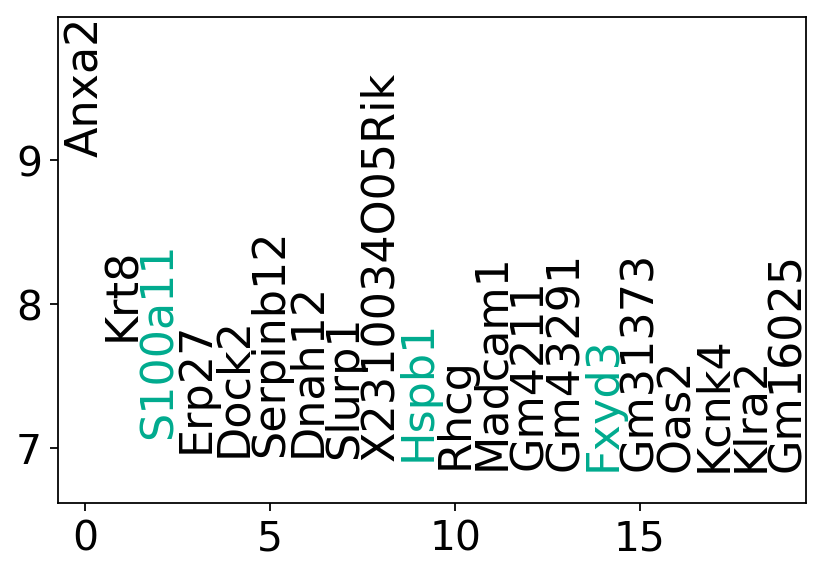

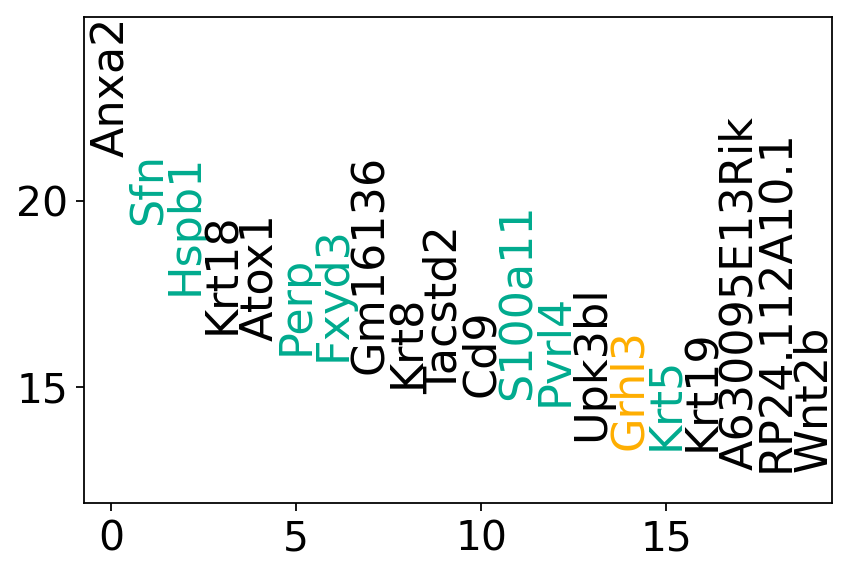

In [24]:
results = {}
gene_names = {}

genes_to_exclude = adata.var_names[
    adata.var_names.str.startswith(("mt.", "Rpl", "Rps", "^Hb[^(p)]")) | adata.var_names.isin(S_GENES + G2M_GENES)
]

for day in [9.5, 10.5, 11.5]:
    results[day] = wot.tmap.diff_exp(adata[adata.obs["day"].isin([day])], fate_ds, compare="all")

    gene_names[day] = (
        results[day][(results[day]["t_fdr"] < 0.01) & (results[day]["name1"] == "mTEC")]
        .sort_values("t_score", ascending=False)
        .index
    )
    gene_names[day] = gene_names[day][~gene_names[day].isin(genes_to_exclude)]

    if len(gene_names[day]) > 0:
        df = pd.DataFrame(
            results[day].loc[gene_names[day][:20], "t_score"],
        )
        df["ranking"] = np.arange(20)

        fig, ax = plt.subplots(figsize=(6, 4))
        y_min = np.min(df["t_score"])
        y_max = np.max(df["t_score"])

        y_min -= 0.1 * (y_max - y_min)
        y_max += 0.4 * (y_max - y_min)
        # ax = fig.add_subplot(gs[count])
        ax.set_ylim(y_min, y_max)

        ax.set_xlim(-0.75, 19.5)

        for gene in df.index:
            if gene in mouse_tfs:
                color = "#FEAE00"
            elif gene in mtec_genes:
                color = "#00AB8E"
            else:
                color = "#000000"
            ax.text(
                df.loc[gene, "ranking"],
                df.loc[gene, "t_score"],
                gene,
                rotation="vertical",
                verticalalignment="bottom",
                horizontalalignment="center",
                fontsize=20,
                color=color,
            )

        if SAVE_FIGURES:
            fig.savefig(
                FIG_DIR
                / "realtime_kernel"
                / "pharyngeal_endoderm"
                / f"genes_ranked_by_t_score_original_wot_day_{day}.eps",
                format="eps",
                transparent=True,
                bbox_inches="tight",
            )

In [25]:
for day, genes in gene_names.items():
    gene_is_tf = genes[:100].isin(mouse_tfs)
    n_tfs = gene_is_tf.sum()
    print(f"Number of TFs in first 100 genes at day {day}: {n_tfs}")

    gene_is_mtec_marker = genes[:100].isin(mtec_genes)
    n_mtec_genes = gene_is_mtec_marker.sum()
    print(f"Number of mTEC genes in first 100 genes at day {day}: {n_mtec_genes}\n")

Number of TFs in first 100 genes at day 9.5: 0
Number of mTEC genes in first 100 genes at day 9.5: 0

Number of TFs in first 100 genes at day 10.5: 2
Number of mTEC genes in first 100 genes at day 10.5: 3

Number of TFs in first 100 genes at day 11.5: 4
Number of mTEC genes in first 100 genes at day 11.5: 8



In [26]:
cr_ranking = pd.read_csv(DATA_DIR / "pharyngeal_endoderm" / "results" / "driver_genes_ranking_cr.csv", index_col=0)
_mtec_genes = list(set(mtec_genes).intersection(cr_ranking.index))

for day in [9.5, 10.5, 11.5]:
    wot_ranking = (
        results[day][results[day]["name1"] == "mTEC"].sort_values("t_score", ascending=False)["t_score"].to_frame()
    )
    wot_ranking["ranking"] = np.arange(wot_ranking.shape[0])

    _perc = (cr_ranking.loc[_mtec_genes, "ranking"] <= wot_ranking.loc[_mtec_genes, "ranking"]).mean() * 100
    print(f"Percentage of genes that CR ranks higher or equal than classical DE (day {day}): {_perc:.2f}%")

    _perc = (cr_ranking.loc[_mtec_genes, "ranking"] < wot_ranking.loc[_mtec_genes, "ranking"]).mean() * 100
    print(f"Percentage of genes that CR ranks strictly higher than classical DE (day {day}): {_perc:.2f}%\n")

Percentage of genes that CR ranks higher or equal than classical DE (day 9.5): 95.24%
Percentage of genes that CR ranks strictly higher than classical DE (day 9.5): 95.24%

Percentage of genes that CR ranks higher or equal than classical DE (day 10.5): 85.71%
Percentage of genes that CR ranks strictly higher than classical DE (day 10.5): 85.71%

Percentage of genes that CR ranks higher or equal than classical DE (day 11.5): 57.14%
Percentage of genes that CR ranks strictly higher than classical DE (day 11.5): 52.38%

